In [7]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
from progressBar import printProgressBar
import torch.optim.lr_scheduler as lr_scheduler #ici

import medicalDataLoader_mathieu
import argparse
import utils

from UNet_Base import *
import random
import torch
import pdb
import matplotlib.pyplot as plt
import numpy as np
import os


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Define hyperparameters
batch_size = 8
batch_size_val = 4
lr =  0.01 *0.65  # Learning Rate
total_epochs = 10  # Number of epochs
weight_decay = 1e-5
epoch_to_load=0

In [11]:
# Define image and mask transformations
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.137], std=[0.1733])
])

mask_transform = v2.Compose([
    v2.ToTensor(),
])

In [12]:
# Define dataloaders
root_dir = './data/'
print(' Dataset: {} '.format(root_dir))

train_set_full = medicalDataLoader_mathieu.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=True,
                                                    equalize=False)

train_loader_full = DataLoader(train_set_full,
                            batch_size=batch_size,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=True)


val_set = medicalDataLoader_mathieu.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)

 Dataset: ./data/ 


Note: Calculating the mean and std only has to be done once and this cell is only for reference. Hence, the parameters do not have to be adapted!

In [13]:
"""Calculate Mean and Std of the dataset"""
# Initialize variables to store the sum and sum of squares of pixel values
mean = 0.0
std = 0.0
nb_samples = 0

for data in train_loader_full:
    images, _, _ = data
    batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

UnidentifiedImageError: cannot identify image file '/home/mathieu/Documents/2024-2025/App prof/Projet/mti865_projet/data/train/Img/patient087_10_8.png'

Image batch dimensions:  torch.Size([8, 1, 256, 256])
Mask batch dimensions:  torch.Size([8, 1, 256, 256])


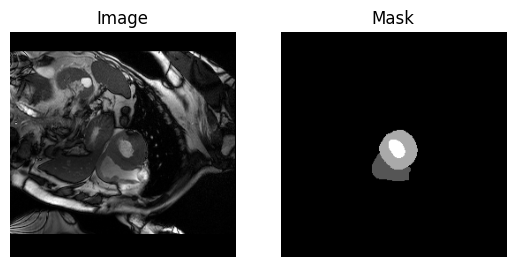

torch.Size([256, 256])


In [ ]:
for i, sample in enumerate(train_loader_full):
    images, masks, _ = sample
    print('Image batch dimensions: ', images.size())
    print('Mask batch dimensions: ', masks.size())
    
    # Show first image and mask
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(images[0,0,:,:], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(masks[0,0,:,:], cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

    print(utils.getTargetSegmentation(masks[0,0,:,:]).shape)

    break

In [ ]:
def runTraining(writer: SummaryWriter,epoch_to_load):
    print("-" * 40)
    print("~~~~~~~~  Starting the training... ~~~~~~")
    print("-" * 40)

    num_classes = 4

    # Set device depending on the availability of GPU
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.mps.is_available():  # Apple M-series of chips
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    print(f"Using device: {device}")

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = "Test_Model"
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = UNet(num_classes).to(device)

    print(
        "Total params: {0:,}".format(
            sum(p.numel() for p in net.parameters() if p.requires_grad)
        )
    )

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    CE_loss = torch.nn.CrossEntropyLoss()

    ce_loss_weight = 0.7
    dice_loss_weight = 0.3

    ## PUT EVERYTHING IN GPU RESOURCES
    # if torch.cuda.is_available():
    #     net.cuda()
    #     softMax.cuda()
    #     CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler= lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.65,total_iters=30)

    ### To save statistics ####
    train_losses = []
    train_dc_losses = []
    val_losses = []
    # val_dc_losses = []

    best_loss_val = 1000

    directory = "Results/Statistics/" + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory) == False:
        os.makedirs(directory)

    ## START THE TRAINING

    ## FOR EACH EPOCH
    for epoch in range(total_epochs):
        net.train()

        num_batches = len(train_loader_full)
        print("Number of batches: ", num_batches)

        running_train_loss = 0
        running_dice_loss = 0

        # Training loop
        for idx, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data

            ### From numpy to torch variables
            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            # Forward pass
            net_predictions = net(images) # Predictions have shape [batch_size, num_classes, height, width]

            # Get the segmentation classes
            segmentation_classes = utils.getTargetSegmentation(labels)
            # Modify segmentation classes to be one-hot encoded (shape [batch_size, num_classes, height, width])
            dice_target = F.one_hot(segmentation_classes, num_classes = num_classes).permute(0,3,1,2).contiguous()

            # Compute the loss
            loss_ce = ce_loss_weight * CE_loss(net_predictions, segmentation_classes)
            loss_dice = dice_loss_weight * DiceLoss()(net_predictions, dice_target)
            loss = loss_ce + loss_dice

            running_train_loss += loss.item()
            # dice_loss = dice_coefficient(net_predictions, labels)
            # dice_loss = utils.compute_dsc(net_predictions, labels)
            #running_dice_loss += loss_dice.item()

            # Backprop
            loss.backward()
            optimizer.step()

            # Add the loss to the tensorboard every 5 batches
            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/train", running_train_loss / (idx + 1), epoch * len(train_loader_full) + idx
                )

            if idx % 100 == 0:
                # Also add visualizations of the images
                probs = torch.softmax(net_predictions, dim=1)
                y_pred = torch.argmax(probs, dim=1)
                writer.add_figure('predictions vs. actuals',
                            utils.plot_net_predictions(images, labels, y_pred, batch_size),
                            global_step=epoch * len(train_loader_full) + idx)

            # THIS IS JUST TO VISUALIZE THE TRAINING
            printProgressBar(
                idx + 1,
                num_batches,
                prefix="[Training] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
            )

        train_loss = running_train_loss / num_batches
        train_losses.append(train_loss)

        train_dc_loss = running_dice_loss / num_batches
        train_dc_losses.append(train_dc_loss)
        
        before_lr=optimizer.param_groups[0]["lr"]
        # if (epoch>=89):
        #     scheduler.step()
        after_lr=optimizer.param_groups[0]["lr"]

        net.eval()
        val_running_loss = 0
        val_running_dc = 0

        # Validation loop
        with torch.no_grad():
            for idx, data in enumerate(val_loader):
                images, labels, img_names = data

                labels = utils.to_var(labels).to(device)
                images = utils.to_var(images).to(device)

                net_predictions = net(images)

                segmentation_classes = utils.getTargetSegmentation(labels)
                dice_target = F.one_hot(segmentation_classes, num_classes = num_classes).permute(0,3,1,2).contiguous()

                loss_ce = ce_loss_weight * CE_loss(net_predictions, segmentation_classes)
                loss_dice = dice_loss_weight * DiceLoss()(net_predictions, dice_target)
                loss = loss_ce + loss_dice

                val_running_loss += loss.item()
                # dice_loss = dice_coefficient(net_predictions, labels)
                # dice_loss = utils.compute_dsc(net_predictions, labels)
                # val_running_dc += dice_loss

                if idx % 10 == 0:
                    writer.add_scalar(
                        "Loss/val",
                        val_running_loss / (idx + 1),
                        epoch * len(val_loader) + idx,
                    )

                printProgressBar(
                    idx + 1,
                    len(val_loader),
                    prefix="[Validation] Epoch: {} ".format(epoch),
                    length=15,
                    suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
                )

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        # dc_loss = val_running_dc / len(val_loader)
        # val_dc_losses.append(dc_loss)
        

        # Check if model performed best and save it if true
        if val_loss < best_loss_val:
            best_loss_val = val_loss
            if not os.path.exists("./models/" + modelName):
                os.makedirs("./models/" + modelName)
            torch.save(
                net.state_dict(), "./models/" + modelName + "/" + str(epoch) + "_Epoch"
            )
            epoch_to_load=epoch
        
        printProgressBar(
            num_batches,
            num_batches,
            done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}, lr: {:.4f} -> {:.4f}".format(
                epoch, train_loss, train_dc_loss, val_loss,before_lr,after_lr
            ),
        )

        # Check if loss has not decreased for 10 epochs
        # if epoch > 10 and val_losses[-1] > val_losses[-10]:
        #     print("Stopping early as validation loss has not decreased for 10 epochs")
        #     break

        np.save(os.path.join(directory, "Losses.npy"), train_losses)
    writer.flush()  # Flush the writer to ensure that all the data is written to disk

In [ ]:
# Set up Tensorboard writer
writer = SummaryWriter()
runTraining(writer,epoch_to_load)
writer.close()

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
Using device: cpu
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
Number of batches:  26
[Training] Epoch: 0 [DONE]                                 
[Validation] Epoch: 0 [DONE]                                 
[Epoch: 0, TrainLoss: 1.0592, TrainDice: 0.0000, ValLoss: 0.8126, lr: 0.0065 -> 0.0065                       
Number of batches:  26
[Training] Epoch: 1 [DONE]                                 
[Validation] Epoch: 1 [DONE]                                 
[Epoch: 1, TrainLoss: 0.6295, TrainDice: 0.0000, ValLoss: 0.3806, lr: 0.0065 -> 0.0065                       
Number of batches:  26
[Training] Epoch: 2 [DONE]                                 
[Validation] Epoch: 2 [DONE]                                 
[Epoch: 2, TrainLoss: 0.2917, TrainDice: 0.0000, ValLoss: 0.2317, 

In [ ]:
from utils import inference
import metrics

# print("epoch_to_load=",epoch_to_load)
epoch_to_load=92
model = UNet(4)
model.load_state_dict(torch.load(f"./models/Test_Model/{epoch_to_load}_Epoch"))
inf_losses = inference(model, val_loader, "test", epoch_to_load)
# Set device depending on the availability of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():  # Apple M-series of chips
    device = torch.device("mps")
else:
    device = torch.device("cpu")


print ("Dice score avec smooth =",metrics.Dice_score_class(model,val_loader,device,1))
print ("Dice score sans smooth =",metrics.Dice_score_class(model,val_loader,device,2))

#Version qui prend longtemps à se calculer
# print ("Soft Dice score sans smooth =",metrics.Dice_score_class(model,val_loader,device,3))

print ("Dice score avec medpy.binary.dc=",metrics.Dice_score_class(model,val_loader,device,4))

print ("Jaccard score avec smooth=",metrics.Jaccard_score_class(model,val_loader,device,1))
print ("Jaccard score sans smooth=",metrics.Jaccard_score_class(model,val_loader,device,2))
print ("Jaccard score avec jc de medpy.binary=",metrics.Jaccard_score_class(model,val_loader,device,3))
print ("Jaccard score avec binary_jaccard_index de torchmetrics=",metrics.Jaccard_score_class(model,val_loader,device,4))
print("HSD score=",metrics.hsd_score_class(model,val_loader,device))



[Inference] Getting segmentations...[>                             ] 0.0%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[=>                            ] 5.3%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[===>                          ] 10.5%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[====>                         ] 15.8%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[======>                       ] 21.1%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[=======>                      ] 26.3%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[=========>                    ] 31.6%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[===========>                  ] 36.8%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[============>                 ] 42.1%torch.Size([4, 4, 256, 256])
[Inference] Getting segmentations...[==============>               ] 47.4%t

In [ ]:
#!tensorboard --logdir=runs